- [Open with Colab](https://github.com/yu-yagi/random_seed_experment/blob/master/random_seed_experiment.ipynb)

# 環境準備

In [1]:
!pip install japanize-matplotlib

In [2]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import japanize_matplotlib
import albumentations as A
import torchvision
from torchvision.transforms.functional import to_tensor
from torch.utils.data import Dataset, DataLoader, get_worker_info
import torchvision.transforms as transforms

SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 検証①
乱数の内部状態の読み込み、書き込み
get_stateで乱数生成器の内部状態を取り出し、set_stateで書き込みしているので、何度実行しても、下のセルで生成される乱数は変わらない

In [3]:


# 1) Python random
state_py = random.getstate()
peek_py = random.random()  # 適当な乱数
random.setstate(state_py)
print("peek random.random() =", peek_py)

# 2) NumPy
state_np = np.random.get_state()
peek_np = np.random.randint(0, 2**31 - 1, dtype=np.int64)  # 適当な乱数
np.random.set_state(state_np)
print("peek np.random.randint =", peek_np)

# 3) PyTorch CPU
state_cpu = torch.get_rng_state()
peek_cpu = torch.empty((), dtype=torch.int64).random_().item()  # 適当な乱数
torch.set_rng_state(state_cpu)
print("peek torch CPU rng =", peek_cpu)

peek random.random() = 0.6394267984578837
peek np.random.randint = 1608637542
peek torch CPU rng = 6909045637428952499


# 検証②
Pytorchデータローダーのnum_worker>0の時、workerプロセスのseedが、メインプロセスで生成した乱数（上のセルの値）+worker_numであることを確かめる

In [4]:
class MyDataset(Dataset):
    def __init__(self):
        self.data = torch.arange(4).float().view(4, 1, 1, 1).repeat(1, 3, 224, 224)

    def __getitem__(self, index):
        x = self.data[index]
        worker_info = get_worker_info()
        if worker_info is None:
            # メインプロセスから呼ばれたとき
            worker_id = None
            seed = None
        else:
            worker_id = worker_info.id
            seed = worker_info.seed

        # 1) Python random
        peek_py = random.random()  # 適当な乱数

        # 2) NumPy
        peek_np = np.random.randint(0, 2**31 - 1, dtype=np.int64)  # 適当な乱数

        # 3) PyTorch CPU
        peek_cpu = torch.empty((), dtype=torch.int64).random_().item() # 適当な乱数
        return worker_id, seed, peek_py, peek_np, peek_cpu

    def __len__(self):
        return len(self.data)

In [5]:
#シード固定
seed_everything(SEED)

### シード固定後、乱数生成（一回目）

In [6]:
state_cpu = torch.get_rng_state() # 乱数生成器の内部状態を読み込む
peek_cpu = torch.empty((), dtype=torch.int64).random_().item()
torch.set_rng_state(state_cpu) # 乱数生成器の内部状態を書き込む（初期値に戻る）
print("peek torch CPU rng =", peek_cpu)

peek torch CPU rng = 6909045637428952499


### 各Worker（サブプロセスのシード値、生成した乱数の値を確かめる）
ワーカーのシードの値は、base_seed(上のセルのRNGの値)+worker_numになる

In [7]:
dataset = MyDataset()

loader = DataLoader(
    dataset,
    batch_size=2,
    num_workers=2,
)

for epoch in range(2):
    print(f'epoch {epoch}')
    for worker_id, seed, py_peek, np_peek, torch_peek in loader:

        print(f"Worker_ID:{worker_id[0]}, Seed:{seed[0]}, Python peek:{py_peek[0]}, Numpy peek:{np_peek[0]}, Pytorch peek:{torch_peek[0]}")
        print(f"Worker_ID:{worker_id[1]}, Seed:{seed[1]}, Python peek:{py_peek[1]}, Numpy peek:{np_peek[1]}, Pytorch peek:{torch_peek[1]}")

epoch 0
Worker_ID:0, Seed:6909045637428952499, Python peek:0.76579821087278, Numpy peek:959832575, Pytorch peek:1170639138655272132
Worker_ID:0, Seed:6909045637428952499, Python peek:0.5290557382213695, Numpy peek:882448501, Pytorch peek:3236260051783816896
Worker_ID:1, Seed:6909045637428952500, Python peek:0.622363687543226, Numpy peek:1662264820, Pytorch peek:2388289256833682258
Worker_ID:1, Seed:6909045637428952500, Python peek:0.1621540338542381, Numpy peek:1141922919, Pytorch peek:5646074976271009539
epoch 1
Worker_ID:0, Seed:8314211556539077902, Python peek:0.497469773115513, Numpy peek:1524043329, Pytorch peek:8205711491232393797
Worker_ID:0, Seed:8314211556539077902, Python peek:0.33839484957051635, Numpy peek:389623752, Pytorch peek:7724067224563570751
Worker_ID:1, Seed:8314211556539077903, Python peek:0.7249762437124196, Numpy peek:595172096, Pytorch peek:3884317797759040003
Worker_ID:1, Seed:8314211556539077903, Python peek:0.8192775489191939, Numpy peek:932636739, Pytorch p

# 検証③ Worker(サブプロセス)に同じseedを設定するとどうなるのか
→ マルチプロセスで同じシードが設定されると、同じ乱数が取り出され、同じエポック内で、同じデータ変換がなされる

## CIFAR10のダウンロード

In [8]:
# メインプロセスのシードを固定
seed_everything(SEED)

# CIFAR‑10 をダウンロード
base_ds = torchvision.datasets.CIFAR10(
        root="./data", download=True, train=False
    )
print("Loaded CIFAR10 test split.")

Loaded CIFAR10 test split.


## データセットクラスの定義

In [9]:
class AugDataset(Dataset):
    def __init__(self, base, alb_aug):
        self.base = base
        self.alb_aug = alb_aug

    def __len__(self):
        # データセットの長さを2としておく
        return 2

    def __getitem__(self, idx):
        img_np, _ = self.base[idx]

        worker_info = get_worker_info()
        worker_id = worker_info.id
        seed = torch.initial_seed()

        #PIL.Image -> ndarray変換
        if not isinstance(img_np, np.ndarray):
            img_np = np.array(img_np)
        out = alb_aug(image=img_np)
        aug_np = out["image"]

        # 1) Python random
        peek_py = random.random() # 適当な乱数生成

        # 2) NumPy
        peek_np = np.random.randint(0, 2**31 - 1, dtype=np.int64)  # 適当な乱数生成

        # 3) PyTorch CPU
        peek_cpu = torch.empty((), dtype=torch.int64).random_().item()
        return to_tensor(aug_np), worker_id, seed, peek_py, peek_np, peek_cpu

### Workerに同じシードを設定し、データ拡張を実施、可視化
→異なるWorkerに同じシード値を設定すると、同じデータ拡張が実施される

[seed_worker] Set seed=42 for all workers.
--------------------Worker_ID:0--------------------
設定されているSeed:42
Pythonで取り出した乱数:0.6394267984578837
Numpyで取り出した乱数:1608637542
Pytorchで取り出した乱数:6909045637428952499
--------------------Worker_ID:1--------------------
設定されているSeed:42
Pythonで取り出した乱数:0.6394267984578837
Numpyで取り出した乱数:1608637542
Pytorchで取り出した乱数:6909045637428952499


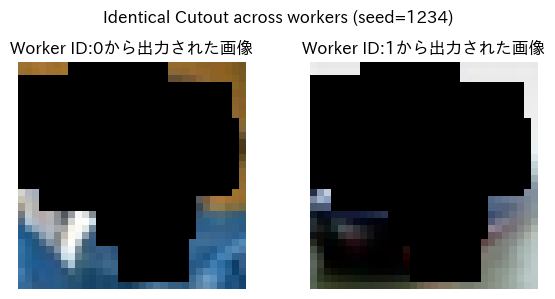

In [10]:
# ワーカーにseedを設定するための関数
def seed_worker(worker_id):
    seed_everything(SEED)
    if worker_id == 0:
        print(f"[seed_worker] Set seed={SEED} for all workers.")

# Albumentations ‑ Cutout (CoarseDropout) を必ず適用 (p=1)
alb_aug = A.Compose(
    [
      A.CoarseDropout(
          num_holes_range=(1, 8),
          hole_height_range=(8, 16),
          hole_width_range=(8, 16),
          fill=0,
          p=1.0
      ),
    ]
)


# 全ワーカーに同一のseedを設定する
loader = DataLoader(
    AugDataset(base_ds, alb_aug),
    batch_size=1,
    num_workers=2,
    shuffle=False,
    worker_init_fn=seed_worker,
)


# 1バッチだけ取得(データローダーの末尾までが1エポック)
for i, (batch_imgs, worker_id, seed, py_peek, np_peek, torch_peek) in enumerate(loader):

    print(f"--------------------Worker_ID:{worker_id[0]}--------------------")
    print(f"設定されているSeed:{seed[0]}")
    print(f"Pythonで取り出した乱数:{py_peek[0]}")
    print(f"Numpyで取り出した乱数:{np_peek[0]}")
    print(f"Pytorchで取り出した乱数:{torch_peek[0]}")

    if i == 0:
      batch_imgs_0 = batch_imgs[0] #Worker_id = 0 (1イテレーション目)
    else:
      batch_imgs_1 = batch_imgs[0] #Worker_id = 1 (2イテレーション目)


# 同じ場所にCutout が入っていることを確認
img1 = (batch_imgs_0.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
img2 = (batch_imgs_1.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Worker ID:0から出力された画像")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Worker ID:1から出力された画像")
plt.axis("off")

plt.suptitle("Identical Cutout across workers (seed=1234)")
plt.tight_layout()
plt.show()
